In [31]:
!pip install opendatasets

In [32]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: abdulrahmanmohammed3
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset


In [33]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

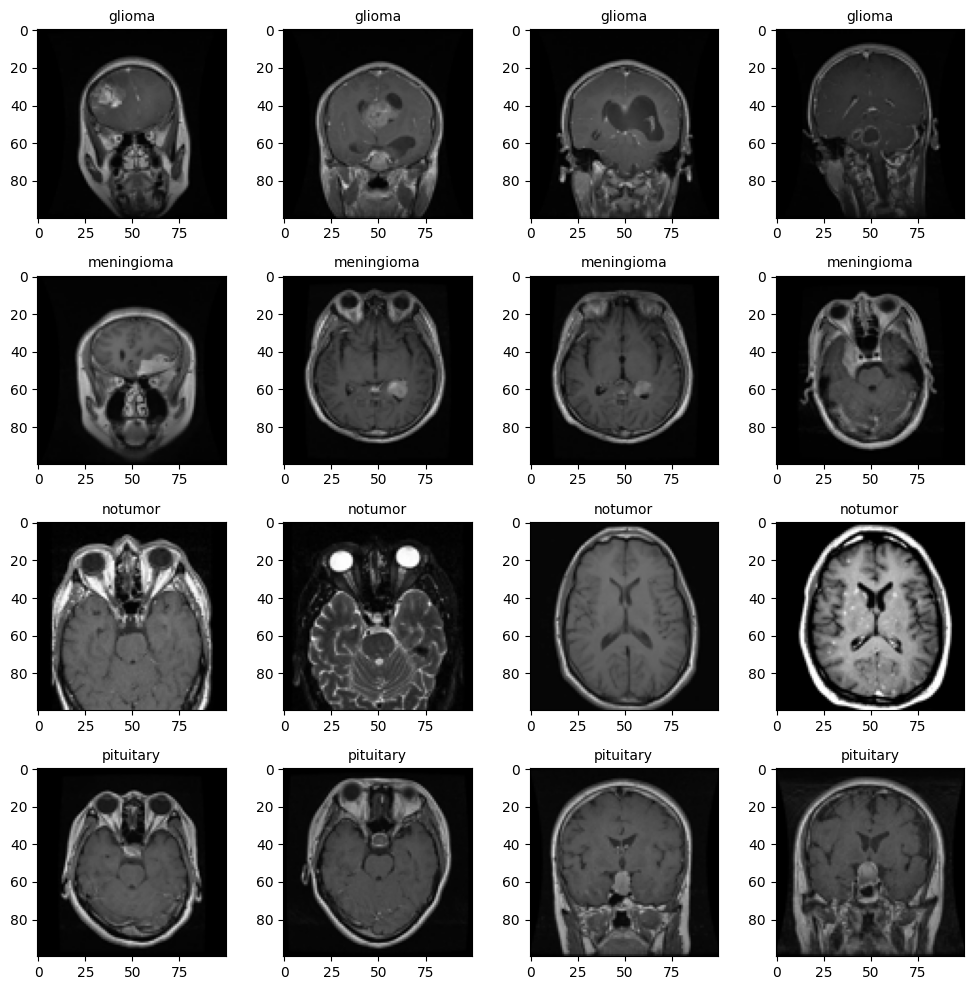

In [34]:
import os
from PIL import Image
import matplotlib.pyplot as plt

main_folder = "/content/brain-tumor-mri-dataset/Training"
max_images_per_class = 4
image_size = (100, 100)

images = []
labels = []

for category in sorted(os.listdir(main_folder)):
    category_path = os.path.join(main_folder, category)
    if not os.path.isdir(category_path):
        continue
    count = 0
    for filename in sorted(os.listdir(category_path)):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(category_path, filename)
            try:
                img = Image.open(img_path).convert("RGB").resize(image_size)
                images.append(img)
                labels.append(category)
                count += 1
                if count >= max_images_per_class:
                    break
            except:
                print(f"Error loading image: {img_path}")

def show_image_grid(images, labels, cols=4):
    rows = (len(images) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
    axes = axes.flatten()

    for ax in axes:
        ax.axis('on')

    for i, (img, label) in enumerate(zip(images, labels)):
        axes[i].imshow(img)
        axes[i].set_title(label, fontsize=10)
        axes[i].axis('on')

    plt.tight_layout()
    plt.show()

show_image_grid(images, labels, cols=4)

In [35]:
import os
from collections import defaultdict
from PIL import Image

def get_data_info(dataset_path):
    data_info = defaultdict(lambda: {"count": 0, "sizes": [], "channels": set()})

    train_path = os.path.join(dataset_path, "Training")
    if not os.path.isdir(train_path):
        return data_info

    for class_name in os.listdir(train_path):
        class_path = os.path.join(train_path, class_name)
        if not os.path.isdir(class_path):
            continue

        for file in os.listdir(class_path):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(class_path, file)
                try:
                    img = Image.open(path)
                    data_info[class_name]["count"] += 1
                    data_info[class_name]["sizes"].append(img.size)
                    data_info[class_name]["channels"].add(img.mode)
                except Exception as e:
                    print(f"Couldn't load image {path}: {e}")

    return data_info

def display_data_info(data_info):
    print("Dataset Info:\n")
    for class_name, info in data_info.items():
        sizes = info["sizes"]
        if sizes:
            widths, heights = zip(*sizes)
            avg_w = sum(widths) // len(widths)
            avg_h = sum(heights) // len(heights)
        else:
            avg_w = avg_h = 0
        channels = ", ".join(info["channels"])
        print(f"{class_name}:")
        print(f"  Total Images: {info['count']}")
        print(f"  Avg Size    : {avg_w}x{avg_h}")
        print(f"  Channels    : {channels}\n")

# Example usage
dataset_path = "/content/brain-tumor-mri-dataset"
data_info = get_data_info(dataset_path)
display_data_info(data_info)

Dataset Info:

notumor:
  Total Images: 1595
  Avg Size    : 313x320
  Channels    : P, RGBA, RGB, L

glioma:
  Total Images: 1321
  Avg Size    : 512x512
  Channels    : L, RGB

pituitary:
  Total Images: 1457
  Avg Size    : 508x508
  Channels    : RGB, L

meningioma:
  Total Images: 1339
  Avg Size    : 493x495
  Channels    : RGB, L



In [36]:
import matplotlib.pyplot as plt

def plot_class_percentages(data_info):
    class_names = list(data_info.keys())
    class_counts = [info["count"] for info in data_info.values()]
    total_count = sum(class_counts)
    percentages = [(count / total_count) * 100 for count in class_counts]

    colors = plt.cm.viridis([i / len(class_names) for i in range(len(class_names))])

    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_names, percentages, color=colors, edgecolor='black')

    for bar, percent in zip(bars, percentages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 1,
                 f"{percent:.1f}%", ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.xlabel("Classes", fontsize=12)
    plt.ylabel("Percentage of Total Images", fontsize=12)
    plt.title("Class Distribution in Dataset (%)", fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

Data Info: defaultdict(<function get_data_info.<locals>.<lambda> at 0x7d966c13ef20>, {'notumor': {'count': 1595, 'sizes': [(225, 225), (630, 630), (236, 236), (150, 198), (225, 225), (416, 512), (218, 231), (173, 201), (680, 680), (234, 234), (200, 252), (232, 217), (630, 630), (228, 221), (550, 664), (201, 251), (236, 251), (220, 212), (201, 251), (225, 225), (225, 225), (225, 225), (201, 250), (214, 236), (630, 630), (201, 251), (442, 442), (225, 225), (173, 201), (227, 300), (350, 350), (630, 630), (680, 680), (201, 250), (227, 262), (200, 248), (225, 225), (173, 201), (236, 300), (236, 236), (201, 250), (441, 442), (236, 260), (890, 1075), (229, 214), (300, 168), (232, 217), (630, 630), (339, 340), (206, 244), (350, 350), (225, 225), (225, 225), (216, 202), (206, 244), (215, 234), (630, 630), (300, 168), (926, 649), (442, 442), (359, 449), (630, 630), (222, 252), (225, 225), (225, 225), (232, 217), (214, 236), (206, 244), (201, 251), (201, 251), (468, 444), (236, 236), (201, 250), 

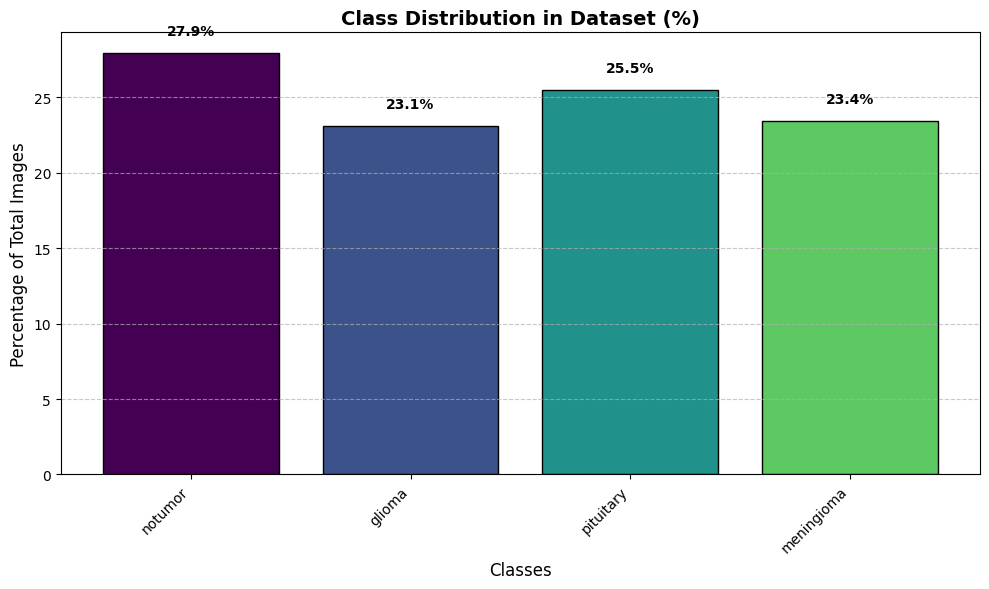

In [37]:
print("Data Info:", data_info)
print("Keys:", list(data_info.keys()))
plot_class_percentages(data_info)

In [38]:
import os
from PIL import Image

def remove_corrupted_images(folder_path):
    removed = 0
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(root, file)
                try:
                    img = Image.open(file_path)
                    img.verify()
                except Exception as e:
                    print(f"Corrupted image removed: {file_path} - {e}")
                    os.remove(file_path)
                    removed += 1

    print(f"Total corrupted images removed: {removed}")

remove_corrupted_images("/content/brain-tumor-mri-dataset/Testing")
remove_corrupted_images("/content/brain-tumor-mri-dataset/Training")


Total corrupted images removed: 0
Total corrupted images removed: 0


In [39]:
img_size = (224, 224)
batch_size = 32
epochs = 30

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    'brain-tumor-mri-dataset/Training',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    'brain-tumor-mri-dataset/Training',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'brain-tumor-mri-dataset/Testing',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,372 (42.61 MB)

 Trainable params: 11,169,924 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

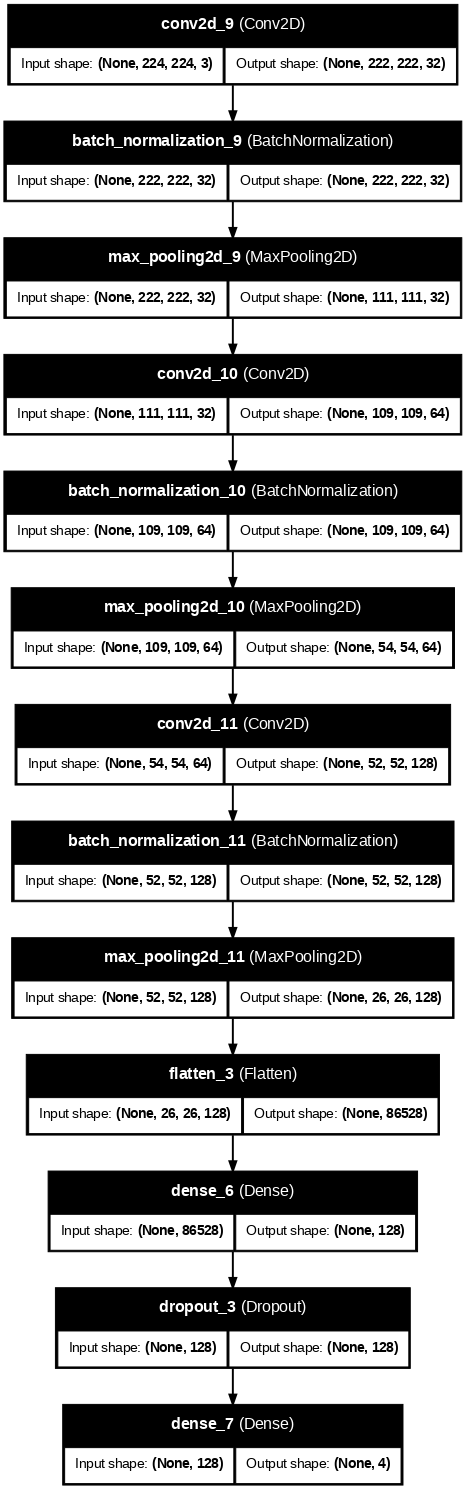

In [53]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, dpi=70)

Image('model.png')


In [41]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 125ms/step - accuracy: 0.6754 - loss: 1.2972 - val_accuracy: 0.2699 - val_loss: 7.9770
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - accuracy: 0.8379 - loss: 0.4321 - val_accuracy: 0.3550 - val_loss: 6.2168
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.8879 - loss: 0.2901 - val_accuracy: 0.6573 - val_loss: 1.1972
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - accuracy: 0.9227 - loss: 0.2099 - val_accuracy: 0.7835 - val_loss: 0.9884
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - accuracy: 0.9251 - loss: 0.1920 - val_accuracy: 0.8265 - val_loss: 0.6467
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.9513 - loss: 0.1415 - val_accuracy: 0.8089 - val_loss: 0.6764
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - accuracy: 0.9550 - loss: 0.1223 - val_accuracy: 0.8221 - val_loss: 0.6693
Epoch 8/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - accuracy: 0.9609 - loss: 0.1000

In [42]:
loss, accuracy = model.evaluate(test_generator)
print(f"\n Test Accuracy: {accuracy * 100:.2f}%")


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.8877 - loss: 0.6828

 Test Accuracy: 92.14%


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step


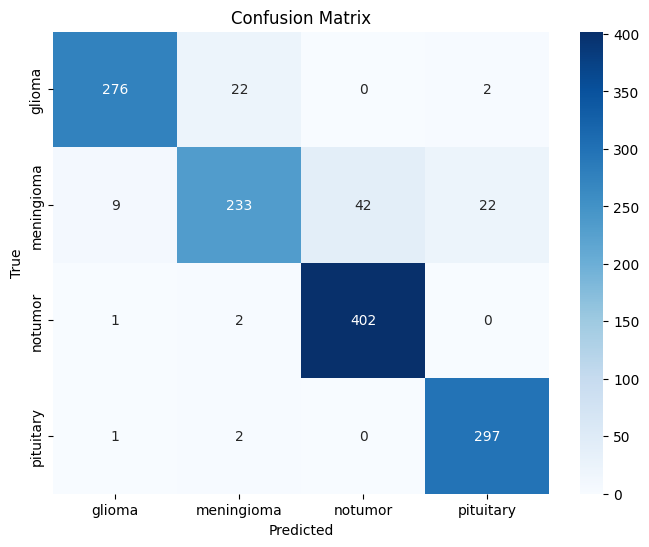


Classification Report:

              precision    recall  f1-score   support

      glioma       0.96      0.92      0.94       300
  meningioma       0.90      0.76      0.82       306
     notumor       0.91      0.99      0.95       405
   pituitary       0.93      0.99      0.96       300

    accuracy                           0.92      1311
   macro avg       0.92      0.92      0.92      1311
weighted avg       0.92      0.92      0.92      1311



In [43]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

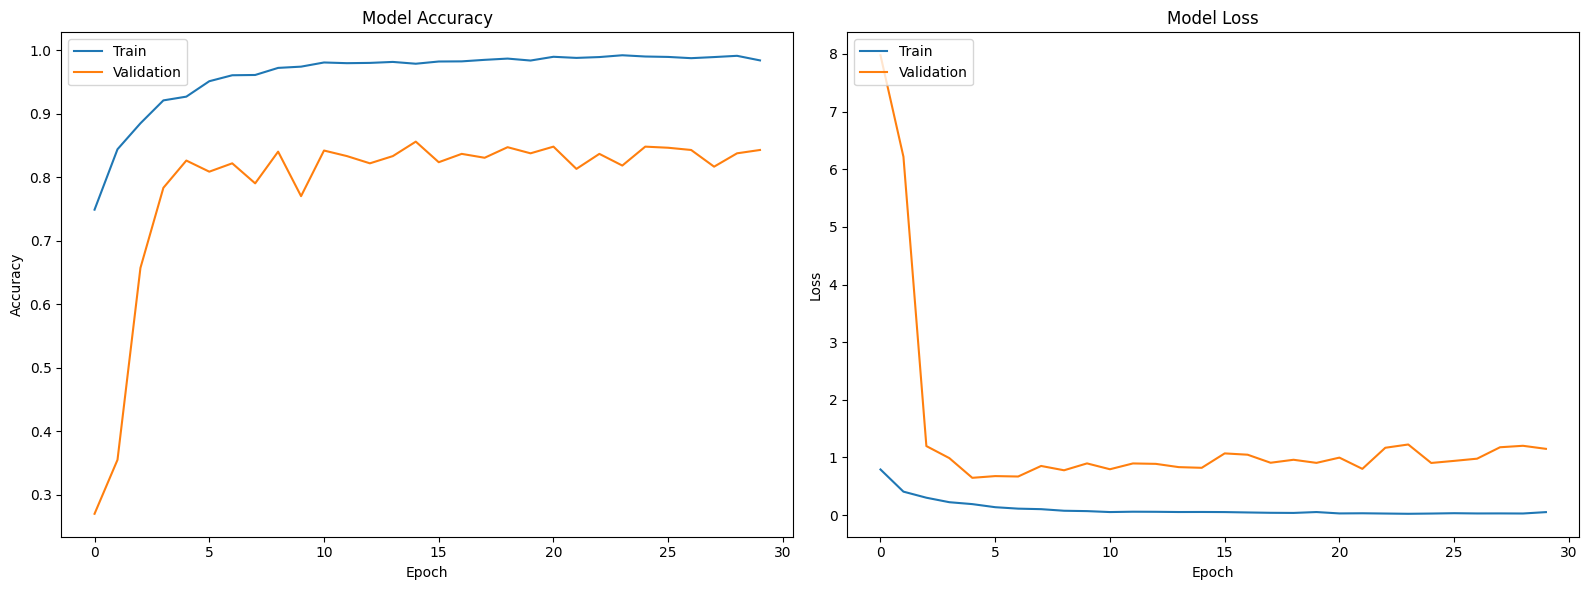

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [46]:
model.save('brainCNN.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction probabilities:
glioma_tumor: 100.00%
meningioma_tumor: 0.00%
no_tumor: 0.00%
pituitary_tumor: 0.00%
Predicted class: glioma_tumor
True class: glioma


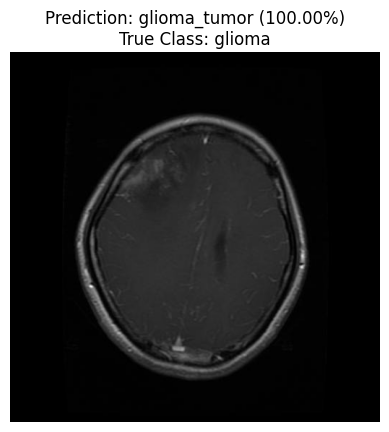

In [47]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

model = load_model('brainCNN.h5')

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255
    return img_array

def predict_image_class(img_path, model, class_labels):
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_class_index]

    true_class = img_path.split("/")[-2]

    print(f"Prediction probabilities:")
    for i, prob in enumerate(prediction[0]):
        print(f"{class_labels[i]}: {prob * 100:.2f}%")

    print(f"Predicted class: {predicted_class}")
    print(f"True class: {true_class}")

    img = plt.imread(img_path)
    plt.imshow(img)

    plt.title(f"Prediction: {predicted_class} ({prediction[0][predicted_class_index] * 100:.2f}%)\nTrue Class: {true_class}")
    plt.axis('off')
    plt.show()

class_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

image_path = "/content/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0002.jpg"
predict_image_class(image_path, model, class_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction probabilities:
glioma_tumor: 0.00%
meningioma_tumor: 0.00%
no_tumor: 0.00%
pituitary_tumor: 100.00%
Predicted class: pituitary_tumor
True class: pituitary


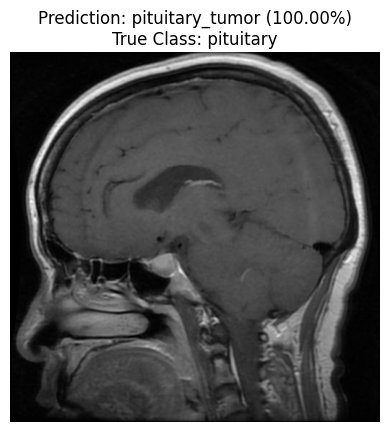

In [48]:
image_path = "/content/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0003.jpg"
predict_image_class(image_path, model, class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction probabilities:
glioma_tumor: 0.00%
meningioma_tumor: 0.00%
no_tumor: 100.00%
pituitary_tumor: 0.00%
Predicted class: no_tumor
True class: notumor


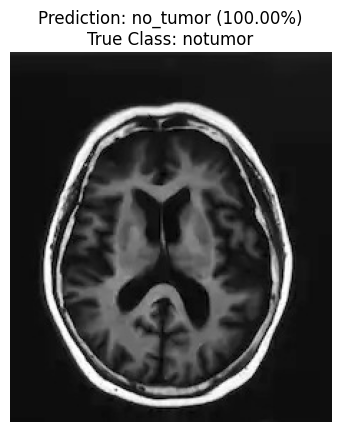

In [49]:
image_path ='/content/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0003.jpg'
predict_image_class(image_path, model, class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction probabilities:
glioma_tumor: 0.00%
meningioma_tumor: 0.00%
no_tumor: 0.10%
pituitary_tumor: 99.90%
Predicted class: pituitary_tumor
True class: meningioma


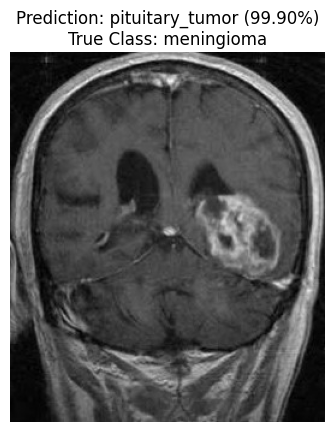

In [50]:
image_path ='/content/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0007.jpg'
predict_image_class(image_path, model, class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction probabilities:
glioma_tumor: 0.00%
meningioma_tumor: 99.82%
no_tumor: 0.18%
pituitary_tumor: 0.00%
Predicted class: meningioma_tumor
True class: meningioma


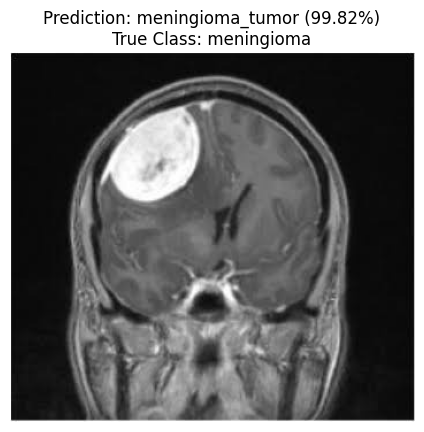

In [51]:
image_path ='/content/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0061.jpg'
predict_image_class(image_path, model, class_labels)